### 라이브러리

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### 데이터 준비하기

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

### date 처리

In [3]:
train['date'] = train['date'].astype(str)
test['date'] = test['date'].astype(str)

def process_date(df):
    df['year'] = df['date'].str[:4].astype(int)
    df['month'] = df['date'].str[4:6].astype(int)
    df['year_month'] = (df['year'] - 2000) * 12 + df['month']
    return df

train = process_date(train)
test = process_date(test)

train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

### target 분리

In [4]:
y = train["price"]
train = train.drop("price", axis=1)

### id 제거

In [5]:
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [6]:
# ===== Feature Engineering =====
train['building_age'] = train['year'] - train['yr_built']
test['building_age'] = test['year'] - test['yr_built']

train['was_renovated'] = (train['yr_renovated'] > 0).astype(int)
test['was_renovated'] = (test['yr_renovated'] > 0).astype(int)

train['living_ratio'] = train['sqft_living'] / (train['sqft_lot'] + 1)
test['living_ratio'] = test['sqft_living'] / (test['sqft_lot'] + 1)

train['basement_ratio'] = train['sqft_basement'] / (train['sqft_living'] + 1)
test['basement_ratio'] = test['sqft_basement'] / (test['sqft_living'] + 1)

train['sqft_per_bedroom'] = train['sqft_living'] / (train['bedrooms'] + 1)
test['sqft_per_bedroom'] = test['sqft_living'] / (test['bedrooms'] + 1)
# ==============================

# zipcode를 categorical로 처리
train['zipcode'] = train['zipcode'].astype('category')
test['zipcode'] = test['zipcode'].astype('category')


### target log 변환

In [7]:
y = np.log1p(y)

In [8]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [9]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [10]:
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.05, 0.03],
    'max_depth': [-1, 10, 15],
}

In [11]:
model = LGBMRegressor(random_state=random_state)

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [13]:
def get_cv_rmse(model, X, y):
    rmse_list = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        score = rmse(y_val, y_pred)
        rmse_list.append(score)

        print(f"Fold {fold + 1} RMSE: {score:.5f}")

    print(f"\nCV RMSE mean: {np.mean(rmse_list):.5f}")
    return np.mean(rmse_list)

get_cv_rmse(model, train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3197
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.047779
Fold 1 RMSE: 111720.41568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3197
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.051002
Fold 2 RMSE: 117952.85429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=tr

np.float64(122031.49181861125)

In [14]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [15]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3195
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.050187
[CV] END ....learning_rate=0.05, max_depth=-1, num_leaves=31; total time=   2.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3226
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.052839
[CV] END ....learning_rate=0.05, max_depth=-1, num_leaves=63; total time=   3.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002

/opt/conda/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3237
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 26
[LightGBM] [Info] Start training from score 13.048122


,learning_rate,max_depth,num_leaves,score,RMSLE
2,0.05,-1,127,-0.027009,0.164343
8,0.05,15,127,-0.027061,0.164502
5,0.05,10,127,-0.027223,0.164994
7,0.05,15,63,-0.027289,0.165195
1,0.05,-1,63,-0.027384,0.165481
4,0.05,10,63,-0.027421,0.165593
6,0.05,15,31,-0.028300,0.168225
0,0.05,-1,31,-0.028301,0.168228
3,0.05,10,31,-0.028328,0.168309
11,0.03,-1,127,-0.029847,0.172762


In [16]:
model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=random_state
)

In [17]:
# ===== XGB용 데이터 (category 제거) =====
train_xgb = train.copy()
test_xgb = test.copy()

train_xgb['zipcode'] = train_xgb['zipcode'].astype(int)
test_xgb['zipcode'] = test_xgb['zipcode'].astype(int)


In [18]:
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=random_state,
    n_jobs=-1
)

In [19]:
# ===== Ensemble Training =====

# LGBM
lgbm_model = model

lgbm_model.fit(train, y)
xgb_model.fit(train_xgb, y)

lgbm_pred = lgbm_model.predict(test)
xgb_pred = xgb_model.predict(test_xgb)

# 가중 평균 (안전한 기본값)
ensemble_pred = 0.6 * lgbm_pred + 0.4 * xgb_pred

# log -> 원래 price
ensemble_pred = np.expm1(ensemble_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3237
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 26
[LightGBM] [Info] Start training from score 13.048122


In [20]:
submission = pd.read_csv("data/sample_submission.csv")
submission['price'] = ensemble_pred

submission.to_csv(
    "data/ensemble_submission_lgbm_xgb.csv",
    index=False
)

print("Ensemble submission saved!")


Ensemble submission saved!


In [21]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '~/work/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [22]:
# import os 
# from os.path import join
# save_submission(model, train, y, test, 'lgbm', rmsle='4')

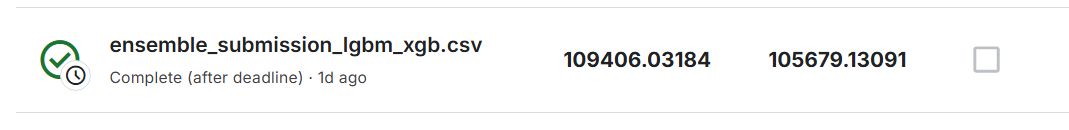